##  Bag of Tweets

####  Eryk Wdowiak and Eric Adsetts

Module 4 project -- sentiment in Tweets

Import the libraries we need (and maybe a few that we didn;t need)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from  nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import xgboost as xgb

Load the data. Remove tweet without text. Rename columns to something easier to work with and make the target data numeric

In [2]:
##  load data
data = pd.read_csv('judge-1377884607_tweet_product_company_v2-clean.csv')
data.columns = ['tweet','direction','emotion']
# data.shape  # (9093, 3)

##  remove rows without tweet
data = data.dropna(subset=['tweet','emotion'],axis='index')
# data.shape  # (9092, 3)

##  clean emotions
emo_dict = {'Negative emotion':'negative', 
            'Positive emotion':'positive',
            'No emotion toward brand or product':'neutral', 
            "I can't tell":'neutral'}
data['emotion'] = data['emotion'].replace(emo_dict)
del emo_dict

#Make target numeric
target_dict = {'negative': 0,
              'positive': 1,
              'neutral': 2}
data['target'] = data['emotion'].map(target_dict)
##  define company and product
##  first convert NaN to a string
data['direction'] = data['direction'].map('{}'.format)

##  define company
comp_dict = {'iPhone':'Apple', 
             'iPad or iPhone App':'Apple', 
             'iPad':'Apple', 
             'Google':'Google', 
             'nan':'unknown', 
             'Android':'Google',
             'Apple':'Apple',
             'Android App':'Google', 
             'Other Google product or service':'Google',
             'Other Apple product or service':'Apple'}
data['company'] = data['direction'].replace(comp_dict)
del comp_dict

##  define product
prod_dict = {'iPhone':'device', 
             'iPad or iPhone App':'software', 
             'iPad':'device', 
             'Google':'company', 
             'nan':'unknown', 
             'Android':'device',
             'Apple':'company',
             'Android App':'software', 
             'Other Google product or service':'other',
             'Other Apple product or service':'other'}
data['product'] = data['direction'].replace(prod_dict)
del prod_dict

##  let's take a look
data.head(10)

,tweet,direction,emotion,target,company,product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,0,Apple,device
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,1,Apple,software
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,1,Apple,device
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,0,Apple,software
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,1,Google,company
5,@teachntech00 New iPad Apps For #SpeechTherapy...,nan,neutral,2,unknown,unknown
7,"#SXSW is just starting, #CTIA is around the co...",Android,positive,1,Google,device
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,positive,1,Apple,software
9,Counting down the days to #sxsw plus strong Ca...,Apple,positive,1,Apple,company
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,positive,1,Google,device


Remove stop words and tokenize and lemmatize tweets

In [3]:
##  prepare stop word list
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['0','1','2','3','4','5','6','7','8','9']

##  process tweets
def process_tweets(tweet):
    tokens = word_tokenize(tweet)
    wnl = WordNetLemmatizer()
    no_stop_lemmas = [wnl.lemmatize(token.lower()) for token in tokens if token.lower() not in stopwords_list]
    ot_string = ' '.join(no_stop_lemmas)
    return ot_string

##  process tweets
data['tweet'] = list(map(process_tweets, list(data['tweet'])))

In [4]:
data['tweet'][0]

'wesley83 3g iphone hr tweeting rise_austin dead need upgrade plugin station sxsw'

perform train test split

In [5]:
##  train test split
X_train, X_test, y_train, y_test = train_test_split(data[['tweet','company','product']], 
                                                    data['target'], 
                                                    test_size=0.20, random_state=42)

In [6]:
X_train

,tweet,company,product
8256,next life 'm coming back ipad woman ca n't kee...,Apple,device
6516,rt mention rt mention best thing 've heard wee...,unknown,unknown
7256,would love meet u rt mention 'll austin conven...,unknown,unknown
2116,iphone crashed front sxsw apple pop-up bestwor...,unknown,unknown
1545,mention mention mention platformer ci di venue...,unknown,unknown
...,...,...,...
5735,rt mention notatsxsw sxsw 's link free downloa...,unknown,unknown
5192,rt mention quot future local contextual discov...,Google,company
5391,rt mention android may gaining market share 'd...,unknown,unknown
861,mention love mention mention sxsw quot apple c...,Apple,company


tf-idf vectorize the data

In [7]:
##  create TF-IDF matrix
vectorizer = TfidfVectorizer(ngram_range = (1,3))
tf_idf_data_train = vectorizer.fit_transform(X_train['tweet'])
tf_idf_data_test = vectorizer.transform(X_test['tweet'])

Classify with naive bayes than run a grid search for optimal hyper parameters. Creates a new naive bayes classifier using these hyperparameters

In [8]:
##  naive bayes classifier
nb_classifier = MultinomialNB(alpha = .1)

nb_classifier.fit(tf_idf_data_train, y_train)
nb_train_preds = nb_classifier.predict(tf_idf_data_train)
nb_test_preds = nb_classifier.predict(tf_idf_data_test)

nb_train_score = accuracy_score(y_train, nb_train_preds)
nb_test_score = accuracy_score(y_test, nb_test_preds)
nb_train_f1 = f1_score(y_train, nb_train_preds, average='weighted')
nb_test_f1 = f1_score(y_test, nb_test_preds, average = 'weighted')

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4}".format(nb_train_score))
print("Testing Accuracy:  {:.4}".format(nb_test_score))
print("Training f1: {:.4}".format(nb_train_f1))
print("Testing f1:  {:.4}".format(nb_test_f1))

Multinomial Naive Bayes
Training Accuracy: 0.9428
Testing Accuracy:  0.6712
Training f1: 0.9427
Testing f1:  0.6531


In [9]:
#hyper parameter tuning
nb_grid = GridSearchCV(nb_classifier, {'alpha': [.01,.1,.25,.5,1]}, n_jobs = -1, verbose = 1)
nb_grid.fit(tf_idf_data_train, y_train)
print(nb_grid.best_score_)
print(nb_grid.best_params_)
nb_grid_preds = nb_grid.predict(tf_idf_data_test)
nb_grid_f1 = f1_score(y_test, nb_grid_preds, average = 'weighted')
print(nb_grid_f1)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


0.6693246737285932
{'alpha': 0.5}
0.6178412200378456


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.5s finished


In [9]:
nb_optimal = MultinomialNB(alpha = .5)
nb_optimal.fit(tf_idf_data_train, y_train)

MultinomialNB(alpha=0.5)

Classify with random forest than run a grid search for optimal hyper parameters. Creates a new random forest classifier using these hyperparameters

In [10]:
##  random forests classifier
rf_classifier = RandomForestClassifier(n_estimators=100, class_weight = 'balanced', max_depth = None, n_jobs = -1)

rf_classifier.fit(tf_idf_data_train, y_train)
rf_train_preds = rf_classifier.predict(tf_idf_data_train)
rf_test_preds = rf_classifier.predict(tf_idf_data_test)

rf_train_score = accuracy_score(y_train, rf_train_preds)
rf_test_score = accuracy_score(y_test, rf_test_preds)
rf_train_f1 = f1_score(y_train, rf_train_preds, average='weighted')
rf_test_f1 = f1_score(y_test, rf_test_preds, average = 'weighted')
    
print('Random Forests')
print("Training Accuracy: {:.4}".format(rf_train_score))
print("Testing Accuracy:  {:.4}".format(rf_test_score))
print("Training f1: {:.4}".format(rf_train_f1))
print("Testing f1:  {:.4}".format(rf_test_f1))

Random Forests
Training Accuracy: 0.9953
Testing Accuracy:  0.6603
Training f1: 0.9953
Testing f1:  0.6188


In [12]:
#hyper parameter tuning
rf_grid = GridSearchCV(rf_classifier, {'n_estimators' : [100,250,500],
                                       'max_depth': [None, 1,3,5],
                                       'min_samples_split': [2,6,10,20]},
                       n_jobs = -1, verbose = 1)
rf_grid.fit(tf_idf_data_train, y_train)
print(rf_grid.best_score_)
print(rf_grid.best_params_)
rf_grid_preds = rf_grid.predict(tf_idf_data_test)
rf_grid_f1 = f1_score(y_test, rf_grid_preds, average = 'weighted')
print(rf_grid_f1)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 16.1min finished


0.6741376555727298
{'max_depth': None, 'min_samples_split': 6, 'n_estimators': 500}
0.643211554738738


In [11]:
rf_optimal = RandomForestClassifier(max_depth = None, min_samples_split = 6, n_estimators = 500, class_weight = 'balanced', n_jobs = -1)

Classify with logistic regression than run a grid search for optimal hyper parameters. Creates a new logistic regression classifier using these hyperparameters. This and svm are our best performing models

In [12]:
#Log Reg
logreg = LogisticRegression(class_weight = 'balanced', n_jobs = -1)

logreg.fit(tf_idf_data_train, y_train)
lr_train_preds = logreg.predict(tf_idf_data_train)
lr_test_preds = logreg.predict(tf_idf_data_test)

lr_train_score = accuracy_score(y_train, lr_train_preds)
lr_test_score = accuracy_score(y_test, lr_test_preds)
lr_train_f1 = f1_score(y_train, lr_train_preds, average='weighted')
lr_test_f1 = f1_score(y_test, lr_test_preds, average = 'weighted')
    
print('Logistic Regression')
print("Training Accuracy: {:.4}".format(lr_train_score))
print("Testing Accuracy:  {:.4}".format(lr_test_score))
print("Training f1: {:.4}".format(lr_train_f1))
print("Testing f1:  {:.4}".format(lr_test_f1))

Logistic Regression
Training Accuracy: 0.9229
Testing Accuracy:  0.6526
Training f1: 0.9234
Testing f1:  0.6558


In [15]:
#hyper parameter tuning
lr_grid = GridSearchCV(logreg, {'C': [-1,-.5,-.1,.1,.5,1,1.5,2,2.5,10,20,25,50]},
                       n_jobs = -1, verbose = 1)
lr_grid.fit(tf_idf_data_train, y_train)
print(lr_grid.best_score_)
print(lr_grid.best_params_)
lr_grid_preds = lr_grid.predict(tf_idf_data_test)
lr_grid_f1 = f1_score(y_test, lr_grid_preds, average = 'weighted')
print(lr_grid_f1)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:   51.4s finished


0.6851351645183094
{'C': 2}
0.6674069043223244


In [13]:
lr_optimal = LogisticRegression(class_weight = 'balanced', n_jobs = -1, C = 2)

Classify with decision tree than run a grid search for optimal hyper parameters. Creates a new decision tree classifier using these hyperparameters

In [14]:
#Decision Tree
tree = DecisionTreeClassifier(class_weight = 'balanced')

tree.fit(tf_idf_data_train, y_train)
dt_train_preds = tree.predict(tf_idf_data_train)
dt_test_preds = tree.predict(tf_idf_data_test)

dt_train_score = accuracy_score(y_train, dt_train_preds)
dt_test_score = accuracy_score(y_test, dt_test_preds)
dt_train_f1 = f1_score(y_train, dt_train_preds, average='weighted')
dt_test_f1 = f1_score(y_test, dt_test_preds, average = 'weighted')
    
print('Decision Tree')
print("Training Accuracy: {:.4}".format(dt_train_score))
print("Testing Accuracy:  {:.4}".format(dt_test_score))
print("Training f1: {:.4}".format(dt_train_f1))
print("Testing f1:  {:.4}".format(dt_test_f1))

Decision Tree
Training Accuracy: 0.9953
Testing Accuracy:  0.5899
Training f1: 0.9953
Testing f1:  0.5912


In [18]:
#hyper parameter tuning
dt_grid = GridSearchCV(tree, {'max_depth': [None, 50,25,10,5], 'min_samples_split': [2,4,8,10,12,14,16],
                             'min_samples_leaf': [1,5,10,15,20]},
                       n_jobs = -1, verbose = 1)
dt_grid.fit(tf_idf_data_train, y_train)
print(dt_grid.best_score_)
print(dt_grid.best_params_)
dt_grid_preds = dt_grid.predict(tf_idf_data_test)
dt_grid_f1 = f1_score(y_test, dt_grid_preds, average = 'weighted')
print(dt_grid_f1)

Fitting 5 folds for each of 175 candidates, totalling 875 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 875 out of 875 | elapsed:  3.8min finished


0.5784370169741488
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4}
0.5983203933920344


In [15]:
dt_optimal = DecisionTreeClassifier(class_weight = 'balanced', max_depth = None, min_samples_leaf = 1, min_samples_split = 4)

Classify with knn than run a grid search for optimal hyper parameters. Creates a new knn classifier using these hyperparameters. Note: the optimal hyperparameters feel weird to me.

In [16]:
#KNN
knn = KNeighborsClassifier()

knn.fit(tf_idf_data_train, y_train)
knn_train_preds = knn.predict(tf_idf_data_train)
knn_test_preds = knn.predict(tf_idf_data_test)

knn_train_score = accuracy_score(y_train, knn_train_preds)
knn_test_score = accuracy_score(y_test, knn_test_preds)
knn_train_f1 = f1_score(y_train, knn_train_preds, average='weighted')
knn_test_f1 = f1_score(y_test, knn_test_preds, average = 'weighted')
    
print('K Nearest Neighbors')
print("Training Accuracy: {:.4}".format(knn_train_score))
print("Testing Accuracy:  {:.4}".format(knn_test_score))
print("Training f1: {:.4}".format(knn_train_f1))
print("Testing f1:  {:.4}".format(knn_test_f1))

K Nearest Neighbors
Training Accuracy: 0.7447
Testing Accuracy:  0.6311
Training f1: 0.7307
Testing f1:  0.6079


In [21]:
#hyper parameter tuning
knn_grid = GridSearchCV(knn, {'n_neighbors': [1,3,5,7,9,11,13,15], 'p': [1,2,3]},
                       n_jobs = -1, verbose = 1)
knn_grid.fit(tf_idf_data_train, y_train)
print(knn_grid.best_score_)
print(knn_grid.best_params_)
knn_grid_preds = knn_grid.predict(tf_idf_data_test)
knn_grid_f1 = f1_score(y_test, knn_grid_preds, average = 'weighted')
print(knn_grid_f1)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   20.4s finished


0.6445766389200074
{'n_neighbors': 1, 'p': 1}
0.6093983363997821


In [17]:
knn_optimal = KNeighborsClassifier(n_neighbors = 1, p = 1)

Classify with support vector machine than run a grid search for optimal hyper parameters. Creates a new support vector machine classifier using these hyperparameters. This and logreg are our best performing models

In [18]:
#SVM
svm = SVC(class_weight = 'balanced')

svm.fit(tf_idf_data_train, y_train)
svm_train_preds = svm.predict(tf_idf_data_train)
svm_test_preds = svm.predict(tf_idf_data_test)

svm_train_score = accuracy_score(y_train, svm_train_preds)
svm_test_score = accuracy_score(y_test, svm_test_preds)
svm_train_f1 = f1_score(y_train, svm_train_preds, average='weighted')
svm_test_f1 = f1_score(y_test, svm_test_preds, average = 'weighted')
    
print('Support Vector Machines')
print("Training Accuracy: {:.4}".format(svm_train_score))
print("Testing Accuracy:  {:.4}".format(svm_test_score))
print("Training f1: {:.4}".format(svm_train_f1))
print("Testing f1:  {:.4}".format(svm_test_f1))

Support Vector Machines
Training Accuracy: 0.9432
Testing Accuracy:  0.6658
Training f1: 0.9436
Testing f1:  0.6617


In [23]:
#hyper parameter tuning
svm_grid = GridSearchCV(svm, {'C': [.5,1,5,10,15,25,50],
                             'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
                       n_jobs = -1, verbose = 1)
svm_grid.fit(tf_idf_data_train, y_train)
print(svm_grid.best_score_)
print(svm_grid.best_params_)
svm_grid_preds = svm_grid.predict(tf_idf_data_test)
svm_grid_f1 = f1_score(y_test, svm_grid_preds, average = 'weighted')
print(svm_grid_f1)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  5.8min finished


0.684860061354623
{'C': 10, 'kernel': 'linear'}
0.6672589469062217


In [19]:
svm_optimal = SVC(class_weight = 'balanced', C = 10, kernel = 'linear')

Classify with xg boost than run a grid search for optimal hyper parameters. Creates a new xg boost classifier using these hyperparameters

In [20]:
xgb_clf = xgb.XGBClassifier(objective = 'multi:softmax', num_classes = 3, n_jobs = -1,
                            verbosity = 1)

xgb_clf.fit(tf_idf_data_train, y_train)
xgb_train_preds = xgb_clf.predict(tf_idf_data_train)
xgb_test_preds = xgb_clf.predict(tf_idf_data_test)

xgb_train_score = accuracy_score(y_train, xgb_train_preds)
xgb_test_score = accuracy_score(y_test, xgb_test_preds)
xgb_train_f1 = f1_score(y_train, xgb_train_preds, average='weighted')
xgb_test_f1 = f1_score(y_test, xgb_test_preds, average = 'weighted')
    
print('Support Vector Machines')
print("Training Accuracy: {:.4}".format(xgb_train_score))
print("Testing Accuracy:  {:.4}".format(xgb_test_score))
print("Training f1: {:.4}".format(xgb_train_f1))
print("Testing f1:  {:.4}".format(xgb_test_f1))

[21:45:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Support Vector Machines
Training Accuracy: 0.8549
Testing Accuracy:  0.6723
Training f1: 0.8464
Testing f1:  0.6357


Note: This cell took almost 3 HOURS to run. Do NOT run again

In [27]:
#hyper parameter tuning
xgb_grid = GridSearchCV(xgb_clf, {'eta': [.01,.05,.1,.15,.2], 'min_child_weight': [.1, 1, 10], 'max_depth': [3, 6, 10],
                                 'subsample': [.5, .75, 1], 'colsample_bytree': [.5,.75,1]},
                       n_jobs = -1, verbose = 1)
xgb_grid.fit(tf_idf_data_train, y_train)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
xgb_grid_preds = xgb_grid.predict(tf_idf_data_test)
xgb_grid_f1 = f1_score(y_test, xgb_grid_preds, average = 'weighted')
print(xgb_grid_f1)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 48.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 84.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 137.0min
[Parallel(n_jobs=-1)]: Done 2025 out of 2025 | elapsed: 164.9min finished


[17:43:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { num_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.680185103778178
{'colsample_bytree': 1, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 0.1, 'subsample': 1}
0.6508281569125254


In [21]:
xgb_optimal = xgb.XGBClassifier(objective = 'multi:softmax', num_classes = 3, n_jobs = -1, colsample_bytree = .5,
                                eta = 0.01, max_depth = 6, min_child_weight = 0.1, subsample = 1,
                            verbosity = 1)

Created a voting classifier using all of our models. Still doesn't perform as well as svm and log reg

In [100]:
voting_clf = VotingClassifier(estimators = [('nb', nb_optimal), ('rf', rf_optimal), ('lr', lr_optimal),('tree', dt_optimal), 
                                            ('knn', knn_optimal), ('svm', svm_optimal), ('xgb', xgb_optimal)],
                              n_jobs = -1)

voting_clf.fit(tf_idf_data_train, y_train)
voting_train_preds = voting_clf.predict(tf_idf_data_train)
voting_test_preds = voting_clf.predict(tf_idf_data_test)

voting_train_score = accuracy_score(y_train, voting_train_preds)
voting_test_score = accuracy_score(y_test, voting_test_preds)
voting_train_f1 = f1_score(y_train, voting_train_preds, average='weighted')
voting_test_f1 = f1_score(y_test, voting_test_preds, average = 'weighted')
    
print('Voting Classifier')
print("Training Accuracy: {:.4}".format(voting_train_score))
print("Testing Accuracy:  {:.4}".format(voting_test_score))
print("Training f1: {:.4}".format(voting_train_f1))
print("Testing f1:  {:.4}".format(voting_test_f1))

Voting Classifier
Training Accuracy: 0.9912
Testing Accuracy:  0.6828
Training f1: 0.9912
Testing f1:  0.6564


Plot a confusion matrix of svm, one of our best performing models

Text(0.5, 1.0, 'SVM Heatmap')

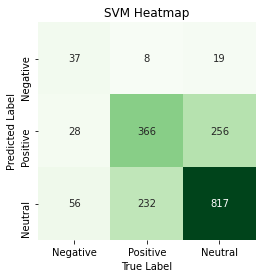

In [32]:
matrix = confusion_matrix(y_test, svm_grid_preds)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative', 'Positive', 'Neutral'], yticklabels=['Negative', 'Positive', 'Neutral'], cmap = 'Greens')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('SVM Heatmap')